##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Distributed training with Core APIs and DTensor

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/core/distribution"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/core/distribution.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/core/distribution.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/core/distribution.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

This notebook uses the [TensorFlow Core low-level APIs](https://www.tensorflow.org/guide/core) and [DTensor](https://www.tensorflow.org/guide/dtensor_overview) to demonstrate a data parallel distributed training example. Visit the [Core APIs overview](https://www.tensorflow.org/guide/core) to learn more about TensorFlow Core and its intended use cases. Refer to the [DTensor Overview](https://www.tensorflow.org/guide/dtensor_overview) guide and [Distributed Training with DTensors](https://www.tensorflow.org/tutorials/distribute/dtensor_ml_tutorial) tutorial to learn more about DTensor.

This example uses the same model and optimizer shown in the [multilayer perceptrons](https://www.tensorflow.org/guide/core/mlp_core) tutorial. See this tutorial first to get comfortable with writing an end-to-end machine learning workflow with the Core APIs.

Note: DTensor is still an experimental TensorFlow API which means that its features are available for testing, and it is intended for use in test environments only.

## Overview of data parallel training with DTensor

Before building an MLP that supports distribution, take a moment to explore the fundamentals of DTensor for data parallel training.

DTensor allows you to run distributed training across devices to improve efficiency, reliability and scalability. DTensor distributes the program and tensors according to the sharding directives through a procedure called Single program, multiple data (SPMD) expansion. A variable of a `DTensor` aware layer is created as `dtensor.DVariable`, and the constructors of `DTensor` aware layer objects take additional `Layout` inputs in addition to the usual layer parameters.

The main ideas for data parallel training are as follows:
 - Model variables are replicated on N devices each.
 - A global batch is split into N per-replica batches.
 - Each per-replica batch is trained on the replica device.
 - The gradient is reduced before weight up data is collectively performed on all replicas.
 - Data parallel training provides nearly linear speed with respect to the number of devices

## Setup

DTensor is part of TensorFlow 2.9.0 release.

In [2]:
#!pip install --quiet --upgrade --pre tensorflow

In [3]:
import matplotlib
from matplotlib import pyplot as plt
# Preset Matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.experimental import dtensor
print(tf.__version__)
# Set random seed for reproducible results 
tf.random.set_seed(22)

2023-10-04 01:30:56.221874: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-04 01:30:56.221918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-04 01:30:56.221966: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.14.0


Configure 8 virtual CPUs for this experiment. DTensor can also be used with GPU or TPU devices. Given that this notebook uses virtual devices, the speedup gained from distributed training is not noticeable. 

In [5]:
def configure_virtual_cpus(ncpu):
  phy_devices = tf.config.list_physical_devices('CPU')
  tf.config.set_logical_device_configuration(phy_devices[0], [
        tf.config.LogicalDeviceConfiguration(),
    ] * ncpu)

configure_virtual_cpus(8)

DEVICES = [f'CPU:{i}' for i in range(8)]
devices = tf.config.list_logical_devices('CPU')
device_names = [d.name for d in devices]
device_names

2023-10-04 01:30:59.029163: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


['/device:CPU:0',
 '/device:CPU:1',
 '/device:CPU:2',
 '/device:CPU:3',
 '/device:CPU:4',
 '/device:CPU:5',
 '/device:CPU:6',
 '/device:CPU:7']

## The MNIST Dataset

The dataset is available from [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/mnist). Split the data into training and testing sets. Only use 5000 examples for training and testing to save time.

In [6]:
train_data, test_data = tfds.load("mnist", split=['train[:5000]', 'test[:5000]'], batch_size=128, as_supervised=True)

### Preprocessing the data

Preprocess the data by reshaping it to be 2-dimensional and by rescaling it to fit into the unit interval, [0,1].

In [7]:
def preprocess(x, y):
  # Reshaping the data
  x = tf.reshape(x, shape=[-1, 784])
  # Rescaling the data
  x = x/255
  return x, y

train_data, test_data = train_data.map(preprocess), test_data.map(preprocess)

## Build the MLP 

Build an MLP model with DTensor aware layers.

### The dense layer

Start by creating a dense layer module that supports DTensor. The `dtensor.call_with_layout` function can be used to call a function that takes in a DTensor input and produces a DTensor output. This is useful for initializing a DTensor variable, `dtensor.DVariable`, with a TensorFlow supported function.

In [8]:
class DenseLayer(tf.Module):

  def __init__(self, in_dim, out_dim, weight_layout, activation=tf.identity):
    super().__init__()
    # Initialize dimensions and the activation function
    self.in_dim, self.out_dim = in_dim, out_dim
    self.activation = activation

    # Initialize the DTensor weights using the Xavier scheme
    uniform_initializer = tf.function(tf.random.stateless_uniform)
    xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(self.in_dim + self.out_dim, tf.float32))
    self.w = dtensor.DVariable(
      dtensor.call_with_layout(
          uniform_initializer, weight_layout,
          shape=(self.in_dim, self.out_dim), seed=(22, 23),
          minval=-xavier_lim, maxval=xavier_lim))
        
    # Initialize the bias with the zeros
    bias_layout = weight_layout.delete([0])
    self.b = dtensor.DVariable(
      dtensor.call_with_layout(tf.zeros, bias_layout, shape=[out_dim]))

  def __call__(self, x):
    # Compute the forward pass
    z = tf.add(tf.matmul(x, self.w), self.b)
    return self.activation(z)

### The MLP sequential model

Now create an MLP module that executes the dense layers sequentially.

In [9]:
class MLP(tf.Module):

  def __init__(self, layers):
    self.layers = layers
   
  def __call__(self, x, preds=False): 
    # Execute the model's layers sequentially
    for layer in self.layers:
      x = layer(x)
    return x

Performing "data-parallel" training with DTensor is equivalent to `tf.distribute.MirroredStrategy`. To do this each device will run the same model on a shard of the data batch. So you'll need the following:

* A `dtensor.Mesh` with a single `"batch"` dimension
* A `dtensor.Layout` for all the weights that replicates them across the mesh (using `dtensor.UNSHARDED` for each axis)
* A `dtensor.Layout` for the data that splits the batch dimension across the mesh





Create a DTensor mesh that consists of a single batch dimension, where each device becomes a replica that receives a shard from the global batch. Use this mesh to instantiate an MLP mode with the following architecture:

Forward Pass: ReLU(784 x 700) x ReLU(700 x 500) x Softmax(500 x 10)


In [10]:
mesh = dtensor.create_mesh([("batch", 8)], devices=DEVICES)
weight_layout = dtensor.Layout([dtensor.UNSHARDED, dtensor.UNSHARDED], mesh)

input_size = 784
hidden_layer_1_size = 700
hidden_layer_2_size = 500
hidden_layer_2_size = 10

mlp_model = MLP([
    DenseLayer(in_dim=input_size, out_dim=hidden_layer_1_size, 
               weight_layout=weight_layout,
               activation=tf.nn.relu),
    DenseLayer(in_dim=hidden_layer_1_size , out_dim=hidden_layer_2_size,
               weight_layout=weight_layout,
               activation=tf.nn.relu),
    DenseLayer(in_dim=hidden_layer_2_size, out_dim=hidden_layer_2_size, 
               weight_layout=weight_layout)])

### Training metrics

Use the cross-entropy loss function and accuracy metric for training.

In [11]:
def cross_entropy_loss(y_pred, y):
  # Compute cross entropy loss with a sparse operation
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(sparse_ce)

def accuracy(y_pred, y):
  # Compute accuracy after extracting class predictions
  class_preds = tf.argmax(y_pred, axis=1)
  is_equal = tf.equal(y, class_preds)
  return tf.reduce_mean(tf.cast(is_equal, tf.float32))

### Optimizer

Using an optimizer can result in significantly faster convergence compared to standard gradient descent. The Adam optimizer is implemented below and has been configured to be compatible with DTensor. In order to use Keras optimizers with DTensor, refer to the experimental`tf.keras.dtensor.experimental.optimizers` module.

In [12]:
class Adam(tf.Module):

    def __init__(self, model_vars, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
      # Initialize optimizer parameters and variable slots
      self.model_vars = model_vars
      self.beta_1 = beta_1
      self.beta_2 = beta_2
      self.learning_rate = learning_rate
      self.ep = ep
      self.t = 1.
      self.v_dvar, self.s_dvar = [], []
      # Initialize optimizer variable slots
      for var in model_vars:
        v = dtensor.DVariable(dtensor.call_with_layout(tf.zeros, var.layout, shape=var.shape))
        s = dtensor.DVariable(dtensor.call_with_layout(tf.zeros, var.layout, shape=var.shape))
        self.v_dvar.append(v)
        self.s_dvar.append(s)

    def apply_gradients(self, grads):
      # Update the model variables given their gradients
      for i, (d_var, var) in enumerate(zip(grads, self.model_vars)):
        self.v_dvar[i].assign(self.beta_1*self.v_dvar[i] + (1-self.beta_1)*d_var)
        self.s_dvar[i].assign(self.beta_2*self.s_dvar[i] + (1-self.beta_2)*tf.square(d_var))
        v_dvar_bc = self.v_dvar[i]/(1-(self.beta_1**self.t))
        s_dvar_bc = self.s_dvar[i]/(1-(self.beta_2**self.t))
        var.assign_sub(self.learning_rate*(v_dvar_bc/(tf.sqrt(s_dvar_bc) + self.ep)))
      self.t += 1.
      return 

### Data packing

Start by writing a helper function for transferring data to the device. This function should use `dtensor.pack` to send (and only send) the shard of the global batch that is intended for a replica to the device backing the replica. For simplicity, assume a single-client application.

Next, write a function that uses this helper function to pack the training data batches into DTensors sharded along the batch (first) axis. This ensures that DTensor evenly distributes the training data to the 'batch' mesh dimension. Note that in DTensor, the batch size always refers to the global batch size; therefore, the batch size should be chosen such that it can be divided evenly by the size of the batch mesh dimension. Additional DTensor APIs to simplify `tf.data` integration are planned, so please stay tuned.

In [13]:
def repack_local_tensor(x, layout):
  # Repacks a local Tensor-like to a DTensor with layout
  # This function assumes a single-client application
  x = tf.convert_to_tensor(x)
  sharded_dims = []

  # For every sharded dimension, use tf.split to split the along the dimension.
  # The result is a nested list of split-tensors in queue[0].
  queue = [x]
  for axis, dim in enumerate(layout.sharding_specs):
    if dim == dtensor.UNSHARDED:
      continue
    num_splits = layout.shape[axis]
    queue = tf.nest.map_structure(lambda x: tf.split(x, num_splits, axis=axis), queue)
    sharded_dims.append(dim)

  # Now you can build the list of component tensors by looking up the location in
  # the nested list of split-tensors created in queue[0].
  components = []
  for locations in layout.mesh.local_device_locations():
    t = queue[0]
    for dim in sharded_dims:
      split_index = locations[dim]  # Only valid on single-client mesh.
      t = t[split_index]
    components.append(t)

  return dtensor.pack(components, layout)

def repack_batch(x, y, mesh):
  # Pack training data batches into DTensors along the batch axis
  x = repack_local_tensor(x, layout=dtensor.Layout(['batch', dtensor.UNSHARDED], mesh))
  y = repack_local_tensor(y, layout=dtensor.Layout(['batch'], mesh))
  return x, y

### Training

Write a traceable function that executes a single training step given a batch of data. This function does not require any special DTensor annotations. Also write a function that executes a test step and returns the appropriate performance metrics.

In [14]:
@tf.function
def train_step(model, x_batch, y_batch, loss, metric, optimizer):
  # Execute a single training step
  with tf.GradientTape() as tape:
    y_pred = model(x_batch)
    batch_loss = loss(y_pred, y_batch)
  # Compute gradients and update the model's parameters
  grads = tape.gradient(batch_loss, model.trainable_variables)
  optimizer.apply_gradients(grads)
  # Return batch loss and accuracy
  batch_acc = metric(y_pred, y_batch)
  return batch_loss, batch_acc

@tf.function
def test_step(model, x_batch, y_batch, loss, metric):
  # Execute a single testing step
  y_pred = model(x_batch)
  batch_loss = loss(y_pred, y_batch)
  batch_acc = metric(y_pred, y_batch)
  return batch_loss, batch_acc

Now, train the MLP model for 3 epochs with a batch size of 128.

In [15]:
# Initialize the training loop parameters and structures
epochs = 3
batch_size = 128
train_losses, test_losses = [], []
train_accs, test_accs = [], []
optimizer = Adam(mlp_model.trainable_variables)

# Format training loop
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate through training data
  for x_batch, y_batch in train_data:
    x_batch, y_batch = repack_batch(x_batch, y_batch, mesh)
    batch_loss, batch_acc = train_step(mlp_model, x_batch, y_batch, cross_entropy_loss, accuracy, optimizer)
   # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate through testing data
  for x_batch, y_batch in test_data:
    x_batch, y_batch = repack_batch(x_batch, y_batch, mesh)
    batch_loss, batch_acc = test_step(mlp_model, x_batch, y_batch, cross_entropy_loss, accuracy)
    # Keep track of batch-level testing
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

# Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  print(f"Epoch: {epoch}")
  print(f"Training loss: {train_loss.numpy():.3f}, Training accuracy: {train_acc.numpy():.3f}")
  print(f"Testing loss: {test_loss.numpy():.3f}, Testing accuracy: {test_acc.numpy():.3f}")

Epoch: 0
Training loss: 1.850, Training accuracy: 0.343
Testing loss: 1.375, Testing accuracy: 0.504


Epoch: 1
Training loss: 1.028, Training accuracy: 0.674
Testing loss: 0.744, Testing accuracy: 0.782


Epoch: 2
Training loss: 0.578, Training accuracy: 0.839
Testing loss: 0.486, Testing accuracy: 0.869


### Performance evaluation

Start by writing a plotting function to visualize the model's loss and accuracy during training. 

In [16]:
def plot_metrics(train_metric, test_metric, metric_type):
  # Visualize metrics vs training Epochs
  plt.figure()
  plt.plot(range(len(train_metric)), train_metric, label = f"Training {metric_type}")
  plt.plot(range(len(test_metric)), test_metric, label = f"Testing {metric_type}")
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.legend()
  plt.title(f"{metric_type} vs Training Epochs");

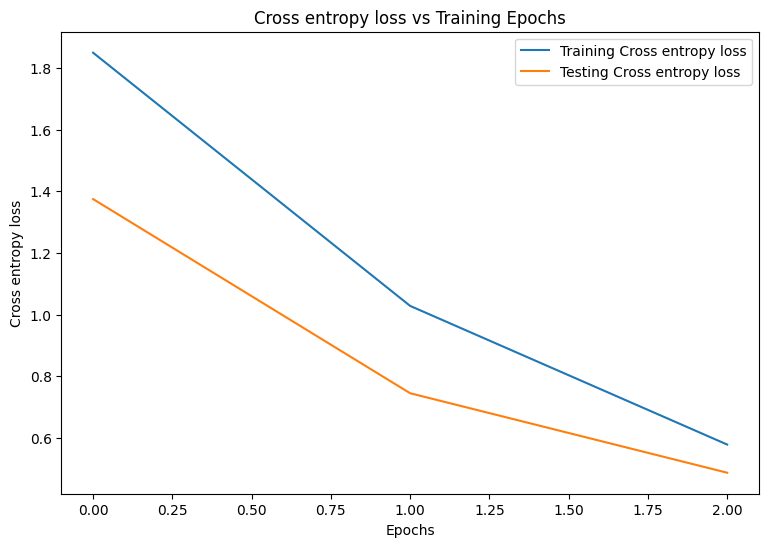

In [17]:
plot_metrics(train_losses, test_losses, "Cross entropy loss")

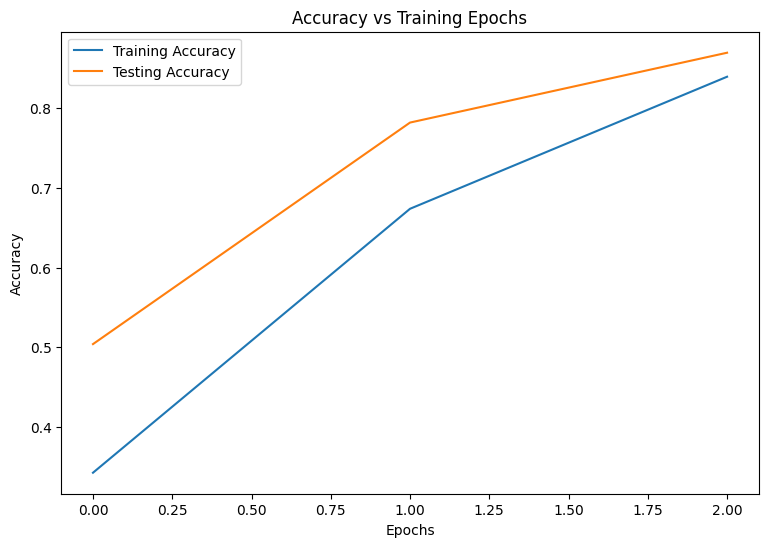

In [18]:
plot_metrics(train_accs, test_accs, "Accuracy")

## Saving your model

The integration of `tf.saved_model` and DTensor is still under development. As of TensorFlow 2.9.0, tf.saved_model only accepts DTensor models with fully replicated variables. As a workaround, you can convert a DTensor model to a fully replicated one by reloading a checkpoint. However, after a model is saved, all DTensor annotations are lost and the saved signatures can only be used with regular Tensors. This tutorial will be updated to showcase the integration once it is solidified.


## Conclusion

This notebook provided an overview of distributed training with DTensor and the TensorFlow Core APIs. Here are a few more tips that may help:

- The [TensorFlow Core APIs](https://www.tensorflow.org/guide/core) can be used to build highly-configurable machine learning workflows with support for distributed training.
- The [DTensor concepts](https://www.tensorflow.org/guide/dtensor_overview) guide and [Distributed training with DTensors](https://www.tensorflow.org/tutorials/distribute/dtensor_ml_tutorial) tutorial contain the most up-to-date information about DTensor and its integrations.

For more examples of using the TensorFlow Core APIs, check out the [guide](https://www.tensorflow.org/guide/core). If you want to learn more about loading and preparing data, see the tutorials on [image data loading](https://www.tensorflow.org/tutorials/load_data/images) or [CSV data loading](https://www.tensorflow.org/tutorials/load_data/csv).